In [2]:
# Середня довжина поїздки вдень та вночі по місяцях (за останній рік) (group by, filter, window)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, month, year, avg, when, max as max_, weekofyear
from pyspark.sql.functions import current_date, add_months, to_date, date_sub, lit
from pyspark.sql.window import Window

In [3]:
spark = SparkSession.builder \
    .appName("TripDurationAnalysis") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 08:48:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/17 08:48:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/17 08:48:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")

In [5]:
df = df_trip.join(df_fare, on=["medallion", "pickup_datetime"])

df = df.withColumn("pickup_dt", to_timestamp("pickup_datetime")) \
       .withColumn("pickup_date", to_date("pickup_dt")) \
       .withColumn("hour", hour("pickup_dt"))

last_date_row = df.agg(max_("pickup_date").alias("last_date")).first()
last_date = last_date_row["last_date"]

df = df.filter((col("pickup_date") >= date_sub(lit(last_date), 14)) & (col("pickup_date") <= lit(last_date)))

df = df.withColumn("time_of_day", when((col("hour") >= 6) & (col("hour") < 18), "day").otherwise("night"))

avg_distance = df.groupBy("pickup_date", "time_of_day") \
    .agg(avg("trip_distance").alias("avg_distance")) \
    .orderBy("pickup_date", "time_of_day")

avg_distance.show()

daily_avg = avg_distance

w = Window.partitionBy("time_of_day")

daily_avg = daily_avg.withColumn("overall_avg", avg("avg_distance").over(w)) \
                     .orderBy("pickup_date", "time_of_day")

daily_avg.show()

daily_avg_pd = daily_avg.toPandas()

daily_avg_pd = daily_avg_pd.sort_values(by=["pickup_date", "time_of_day"])

daily_avg_pd["date"] = daily_avg_pd["pickup_date"].astype(str)



Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=17946Kb max_used=17957Kb free=113125Kb
 bounds [0x000000010b9f8000, 0x000000010cb98000, 0x00000001139f8000]
 total_blobs=7567 nmethods=6607 adapters=873
 compilation: disabled (not enough contiguous free space left)


+-----------+-----------+------------------+
|pickup_date|time_of_day|      avg_distance|
+-----------+-----------+------------------+
| 2013-01-13|        day| 2.958391347708636|
| 2013-01-13|      night| 3.150834017767157|
| 2013-01-14|        day|2.6791657352612406|
| 2013-01-14|      night|3.0189156612940486|
| 2013-01-15|        day|2.5417625004005746|
| 2013-01-15|      night|2.8770038516314393|
| 2013-01-16|        day|2.5788385352964416|
| 2013-01-16|      night|2.9045972300394953|
| 2013-01-17|        day|2.6577932727594873|
| 2013-01-17|      night|2.9641520794842977|
| 2013-01-18|        day| 2.652812148362407|
| 2013-01-18|      night| 2.849646594848839|
| 2013-01-19|        day|2.6559118098686754|
| 2013-01-19|      night| 2.801952477534484|
| 2013-01-20|        day| 2.839033183802321|
| 2013-01-20|      night| 2.965116745084523|
| 2013-01-21|        day|2.8838742198751803|
| 2013-01-21|      night| 3.235357710554254|
| 2013-01-22|        day|2.5225659985482216|
| 2013-01-

+-----------+-----------+------------------+------------------+
|pickup_date|time_of_day|      avg_distance|       overall_avg|
+-----------+-----------+------------------+------------------+
| 2013-01-13|        day| 2.958391347708636|2.6429962840120025|
| 2013-01-13|      night| 3.150834017767157|2.9049538888278956|
| 2013-01-14|        day|2.6791657352612406|2.6429962840120025|
| 2013-01-14|      night|3.0189156612940486|2.9049538888278956|
| 2013-01-15|        day|2.5417625004005746|2.6429962840120025|
| 2013-01-15|      night|2.8770038516314393|2.9049538888278956|
| 2013-01-16|        day|2.5788385352964416|2.6429962840120025|
| 2013-01-16|      night|2.9045972300394953|2.9049538888278956|
| 2013-01-17|        day|2.6577932727594873|2.6429962840120025|
| 2013-01-17|      night|2.9641520794842977|2.9049538888278956|
| 2013-01-18|        day| 2.652812148362407|2.6429962840120025|
| 2013-01-18|      night| 2.849646594848839|2.9049538888278956|
| 2013-01-19|        day|2.6559118098686

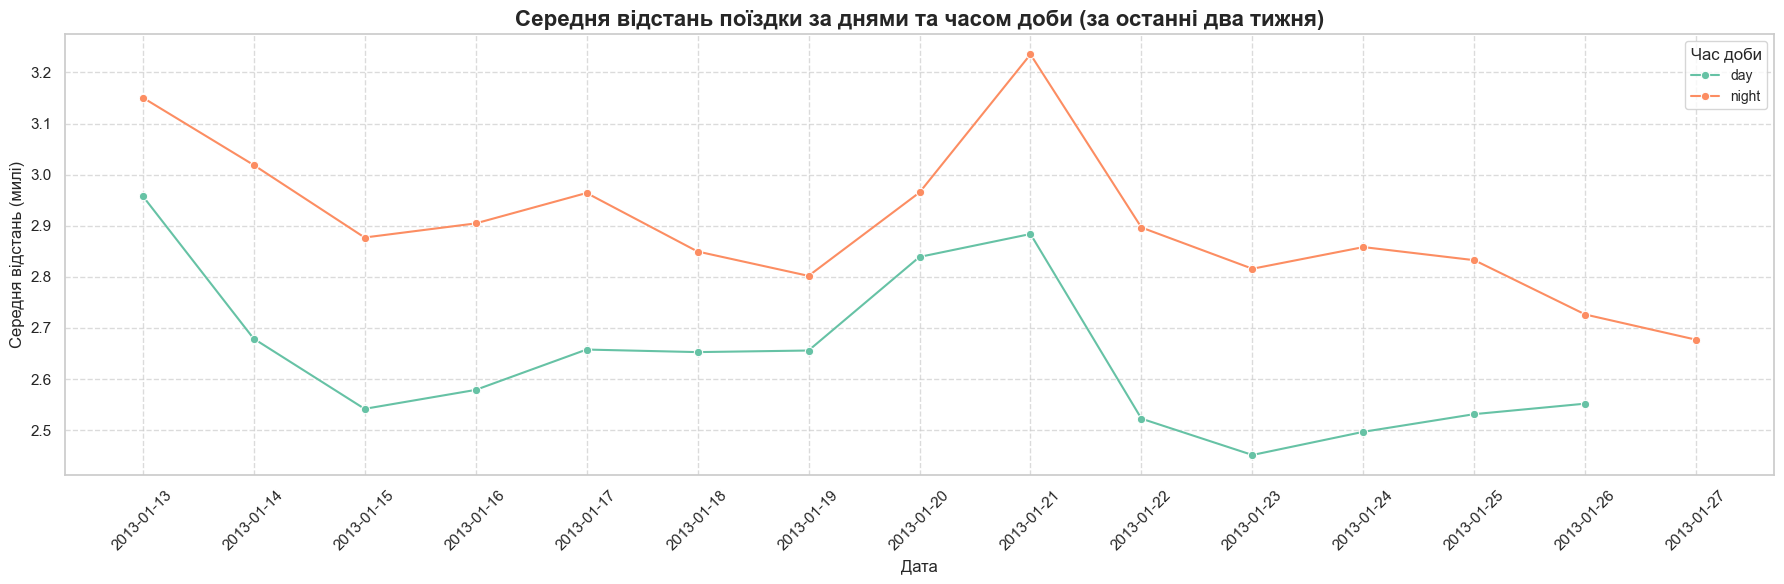

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(18, 6))
sns.lineplot(
    data=daily_avg_pd,
    x="date",
    y="avg_distance",
    hue="time_of_day",
    marker="o",
    linewidth=1.5
)

plt.title("Середня відстань поїздки за днями та часом доби (за останні два тижня)", fontsize=16, weight='bold')
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Середня відстань (милі)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Час доби", title_fontsize=12, fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
daily_avg.coalesce(1).write.mode("overwrite").csv("/Users/mac/Development/nyc-taxi-spark-project/results/4.csv")